In [ ]:
!git clone https://github.com/tensorflow/examples.git

Cloning into 'examples'...
remote: Enumerating objects: 23379, done.
remote: Counting objects: 100% (340/340), done.
remote: Compressing objects: 100% (194/194), done.
remote: Total 23379 (delta 106), reused 313 (delta 94), pack-reused 23039
Receiving objects: 100% (23379/23379), 43.88 MiB | 21.42 MiB/s, done.
Resolving deltas: 100% (12756/12756), done.


In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
from examples.tensorflow_examples.models.pix2pix import pix2pix
from IPython.display import clear_output
import matplotlib.pyplot as plt

import numpy as np
from tensorflow import keras
from tensorflow.keras import activations
%matplotlib inline
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.layers import UpSampling2D, Concatenate
from tensorflow.keras import utils

In [ ]:
dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)
dataset

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteFP5Z5W/oxford_iiit_pet-train.tfrecord*...:…

Generating test examples...:   0%|          | 0/3669 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteFP5Z5W/oxford_iiit_pet-test.tfrecord*...: …

Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0. Subsequent calls will reuse this data.


{'train': <_PrefetchDataset element_spec={'file_name': TensorSpec(shape=(), dtype=tf.string, name=None), 'image': TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None), 'segmentation_mask': TensorSpec(shape=(None, None, 1), dtype=tf.uint8, name=None), 'species': TensorSpec(shape=(), dtype=tf.int64, name=None)}>,
 'test': <_PrefetchDataset element_spec={'file_name': TensorSpec(shape=(), dtype=tf.string, name=None), 'image': TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None), 'segmentation_mask': TensorSpec(shape=(None, None, 1), dtype=tf.uint8, name=None), 'species': TensorSpec(shape=(), dtype=tf.int64, name=None)}>}

In [ ]:
def normalize(input_image, input_mask):
  input_image = tf.cast(input_image, tf.float32) / 255.0
  input_mask -= 1
  return input_image, input_mask

In [ ]:
def load_train(dataset):
  input_image = tf.image.resize(dataset['image'], size=(width, height))
  input_mask = tf.image.resize(dataset['segmentation_mask'], size=(width, height))

  if tf.random.uniform(()) > 0.5:
    input_image = tf.image.flip_left_right(input_image)
    input_mask = tf.image.flip_left_right(input_mask)
  
  input_image, input_mask = normalize(input_image, input_mask)
  return input_image, input_mask


In [ ]:
def load_test(dataset):
  input_image = tf.image.resize(dataset['image'], size=(width, height))
  input_mask = tf.image.resize(dataset['segmentation_mask'], size=(width, height))
  
  input_image, input_mask = normalize(input_image, input_mask)
  return input_image, input_mask


In [ ]:
TRAIN_LENGTH = info.splits['train'].num_examples
BATCH_SIZE = 64
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE
width, height = 224, 224

In [ ]:
train_images = dataset['train'].map(load_train, num_parallel_calls=tf.data.AUTOTUNE)
test_images = dataset['test'].map(load_test, num_parallel_calls=tf.data.AUTOTUNE)

In [ ]:
class Augment(tf.keras.layers.Layer):
  def __init__(self, seed=42):
    super().__init__()
    self.augment_inputs = tf.keras.layers.RandomFlip(mode="horizontal", seed=seed)
    self.augment_labels = tf.keras.layers.RandomFlip(mode="horizontal", seed=seed)

  def call(self, inputs, labels):
    inputs = self.augment_inputs(inputs)
    labels = self.augment_labels(labels)
    return inputs, labels

In [ ]:
train_batches = (
    train_images
    .cache()
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE)
    .repeat()
    .map(Augment())
    .prefetch(buffer_size=tf.data.AUTOTUNE))

test_batches = test_images.batch(BATCH_SIZE)

In [ ]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

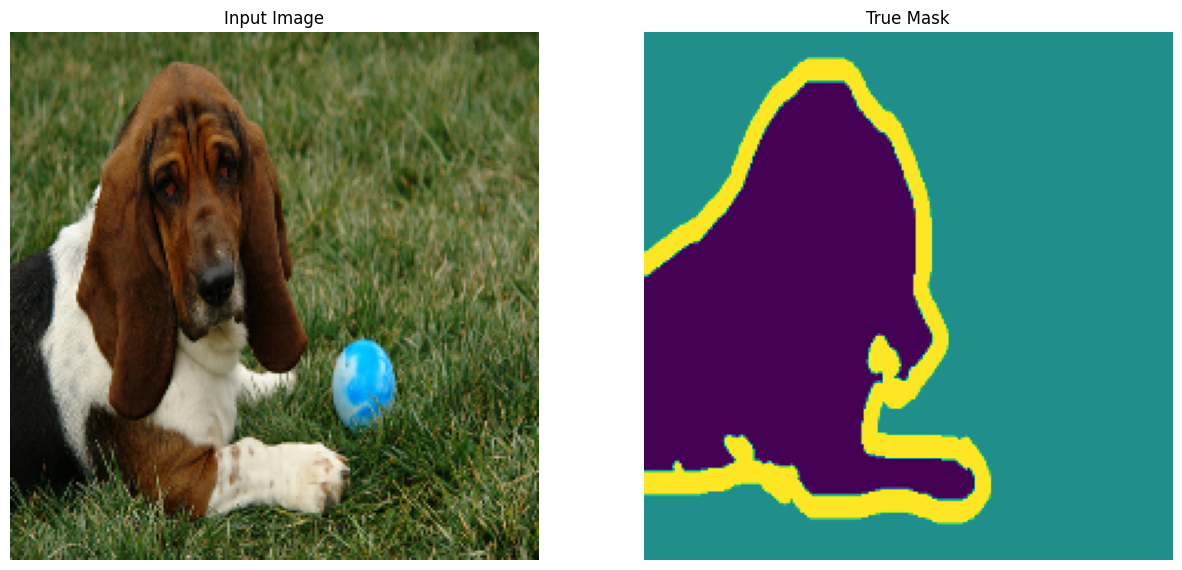

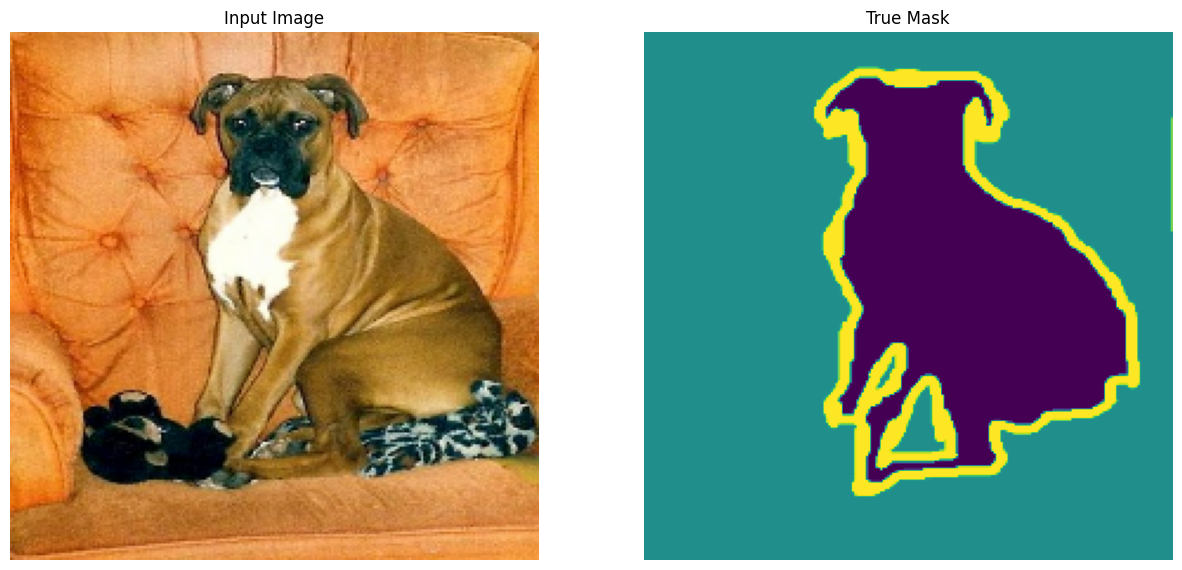

In [ ]:
for images, masks in train_batches.take(2):
  sample_image, sample_mask = images[1], masks[1]
  display([sample_image, sample_mask])

In [ ]:
class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    clear_output(wait=True)
    show_predictions()
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

In [ ]:
class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    clear_output(wait=True)
    show_predictions()
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

In [ ]:
inp = Input(shape=(128, 128, 3))

conv_1_1 = Conv2D(32, (3,3), padding = 'same', activation='relu')(inp)
conv_1_2 = Conv2D(32, (3,3), padding = 'same', activation='relu')(conv_1_1)

pool_1 = MaxPooling2D(2)(conv_1_2)

conv_2_1 = Conv2D(64, (3,3), padding = 'same', activation='relu')(pool_1)
conv_2_2 = Conv2D(64, (3,3), padding = 'same', activation='relu')(conv_2_1)

pool_2 = MaxPooling2D(2)(conv_2_2)

conv_3_1 = Conv2D(128, (3,3), padding = 'same', activation='relu')(pool_2)
conv_3_2 = Conv2D(128, (3,3), padding = 'same', activation='relu')(conv_3_1)

pool_3 = MaxPooling2D(2)(conv_3_2)

conv_4_1 = Conv2D(256, (3,3), padding = 'same', activation='relu')(pool_3)
conv_4_2 = Conv2D(256, (3,3), padding = 'same', activation='relu')(conv_4_1)

pool_4 = MaxPooling2D(2)(conv_4_2)

up_1 = UpSampling2D(2, interpolation='bilinear')(pool_4)
conc_1 = keras.layers.Concatenate()([conv_4_2, up_1])
conv_up_1_1 = Conv2D(256, (3,3), padding = 'same', activation='relu')(conc_1)
conv_up_1_2 = Conv2D(256, (3,3), padding = 'same', activation='relu')(conv_up_1_1)

up_2 = UpSampling2D(2, interpolation='bilinear')(conv_up_1_2)
conc_2 = keras.layers.Concatenate()([conv_3_2, up_2])
conv_up_2_1 = Conv2D(128, (3,3), padding = 'same', activation='relu')(conc_2)
conv_up_2_2 = Conv2D(128, (3,3), padding = 'same', activation='relu')(conv_up_2_1)

up_3 = UpSampling2D(2, interpolation='bilinear')(conv_up_2_2)
conc_3 = keras.layers.Concatenate()([conv_2_2, up_3])
conv_up_3_1 = Conv2D(64, (3,3), padding = 'same', activation='relu')(conc_3)
conv_up_3_2 = Conv2D(64, (3,3), padding = 'same', activation='relu')(conv_up_3_1)

up_4 = UpSampling2D(2, interpolation='bilinear')(conv_up_3_2)
conc_4 = keras.layers.Concatenate()([conv_1_2, up_4])
conv_up_4_1 = Conv2D(32, (3,3), padding = 'same', activation='relu')(conc_4)
conv_up_4_2 = Conv2D(3, (3,3), padding = 'same', activation='softmax')(conv_up_4_1)

model = Model(inputs = inp, outputs = conv_up_4_2)

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

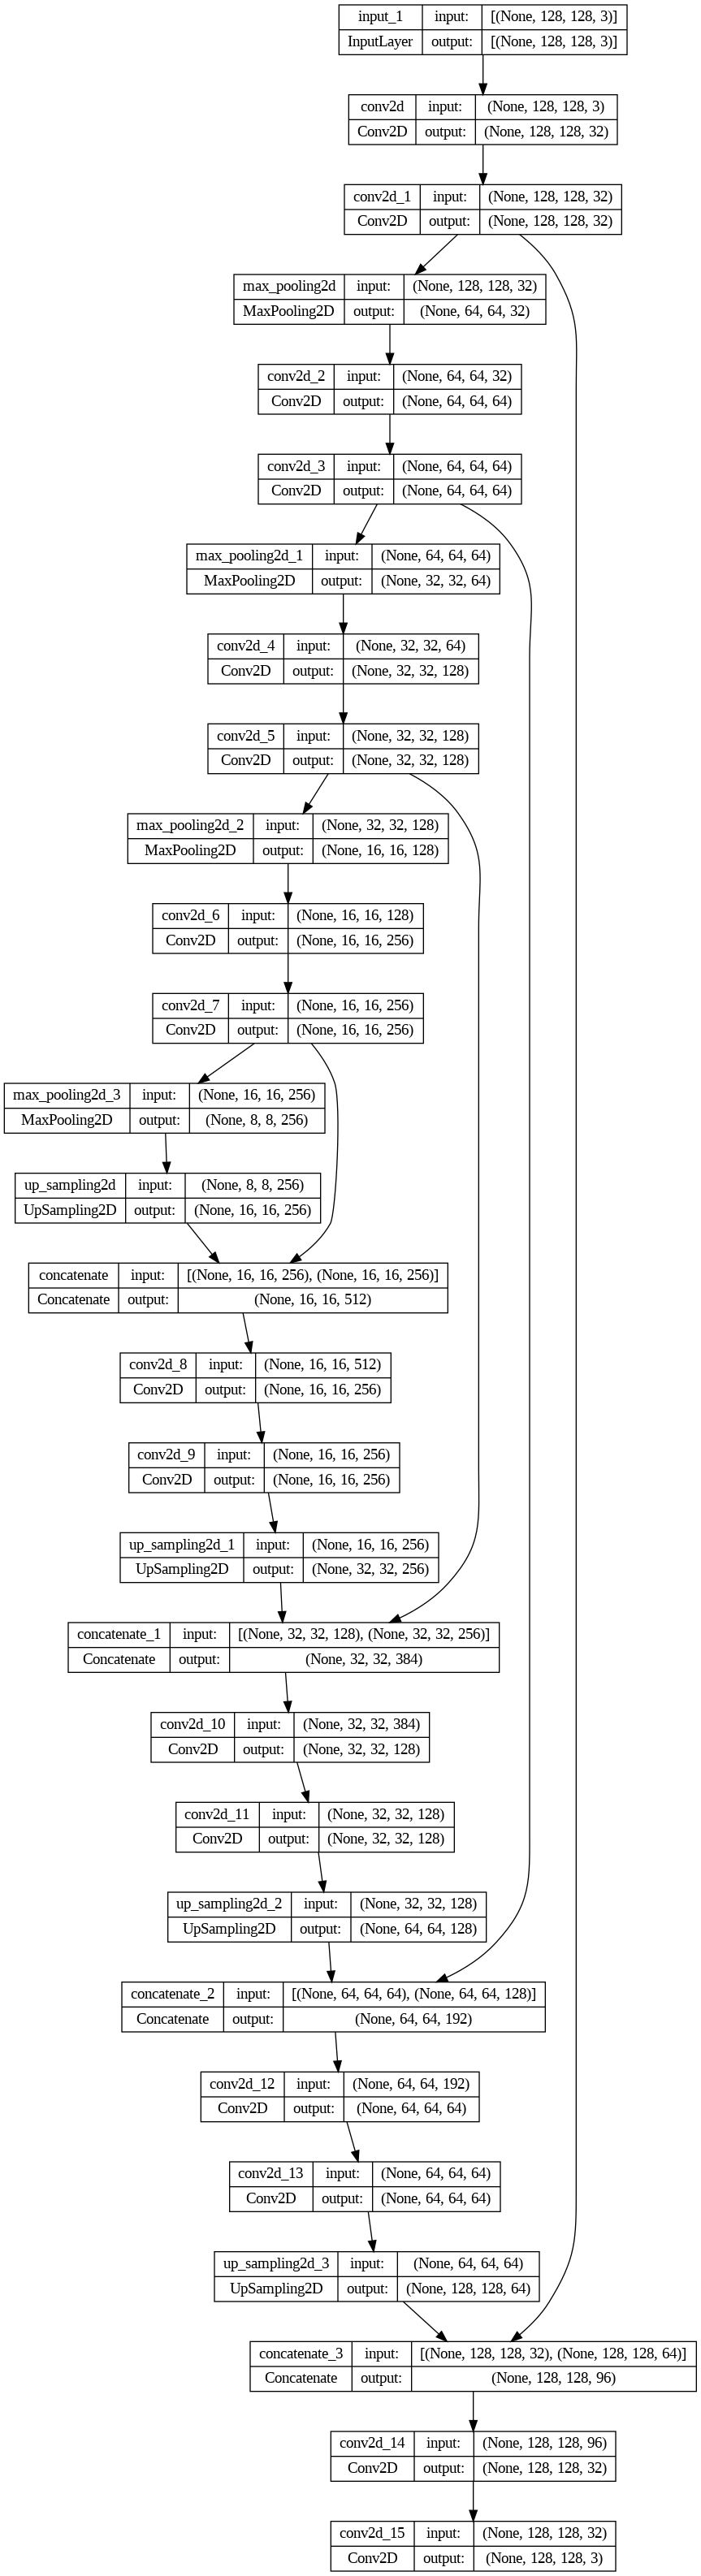

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
def create_mask(pred_mask):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[1]

In [ ]:
def show_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image)
      display([image[1], mask[1], create_mask(pred_mask)])
  else:
    display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])

In [ ]:
show_predictions()

ValueError: ignored

In [ ]:
EPOCHS = 3
VAL_SUBSPLITS = 5
VALIDATION_STEPS = info.splits['test'].num_examples//BATCH_SIZE//VAL_SUBSPLITS

model_history = model.fit(train_batches, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_batches,
                          callbacks=[DisplayCallback()])

Epoch 1/3


ValueError: ignored

In [ ]:
show_predictions(test_batches, 3)

ValueError: ignored